<a href="https://colab.research.google.com/github/peeyushsinghal/EVA8/blob/main/S9-Assignment-Solution/EVA8_S9_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 9:
Build the following network

1. That takes a CIFAR10 image (32x32x3)
2. Add 3 Convolutions to arrive at AxAx48 dimensions (e.g. 32x32x3 | 3x3x3x16 >> 3x3x16x32 >> 3x3x32x48)
3. Apply GAP and get 1x1x48, call this X
4. Create a block called ULTIMUS that:
  - Creates 3 FC layers called K, Q and V such that:
    - X\*K = 48*48x8 > 8
    - X\*Q = 48*48x8 > 8 
    - X\*V = 48*48x8 > 8 
  - then create AM = SoftMax(QTK)/(8^0.5) = 8*8 = 8
  - then Z = V\*AM = 8*8 > 8
  - then another FC layer called Out that:
    - Z\*Out = 8*8x48 > 48
5. Repeat this Ultimus block 4 times
6. Then add final FC layer that converts 48 to 10 and sends it to the loss function.
7. Model would look like this C>C>C>U>U>U>U>FFC>Loss
8. Train the model for 24 epochs using the OCP that I wrote in class. Use ADAM as an optimizer. 
9. Submit the link and answer the questions on the assignment page:
  - Share the link to the main repo (must have Assignment 7/8/9 model7/8/9.py files (or similarly named))
  - Share the code of model9.py
  - Copy and paste the Training Log
  - Copy and paste the training and validation loss chart

In [1]:
!pip install torchinfo -q --quiet
!pip install torch_lr_finder -q --quiet

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#@title importing model, mains, utils
!rm -rf ./*
!git clone https://github.com/peeyushsinghal/pytorch-models-utils.git
!mv pytorch-models-utils/* ./
!rm -rf pytorch-models-utils

Cloning into 'pytorch-models-utils'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 118 (delta 21), reused 0 (delta 0), pack-reused 78
Receiving objects: 100% (118/118), 36.65 KiB | 1.36 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [4]:
#@title setting seed and device

# loading helper functions
from utils.helper import seed_all, get_device, get_mean_std_dev

# check for default device

device = get_device()
print (f' device Status : {device}')

 device Status : cuda


In [5]:
## setting seed for reproducibility
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
seed_all(SEED)

In [6]:
#@title Preparing Data

from utils.helper import get_mean_std_dev

# getting mean and standard deviation of CIFAR 10
mean,std = get_mean_std_dev('CIFAR10')
print (mean, std)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
(0.4913996786152028, 0.4821584083946074, 0.4465309144454644) (0.24703223246328238, 0.2434851280000556, 0.26158784172796423)


In [7]:
#@title applying transformations
from utils.transforms import apply_transforms_resnet

# reusing the resnet transforms for this too
train_transforms, test_transforms = apply_transforms_resnet(mean,std)

In [8]:
#@title Train and Test Data

from torchvision import datasets

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
#@title Labels
labels = trainset.classes
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
#@title Train and Test set Dataloader

import torch
batch_size = 128

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

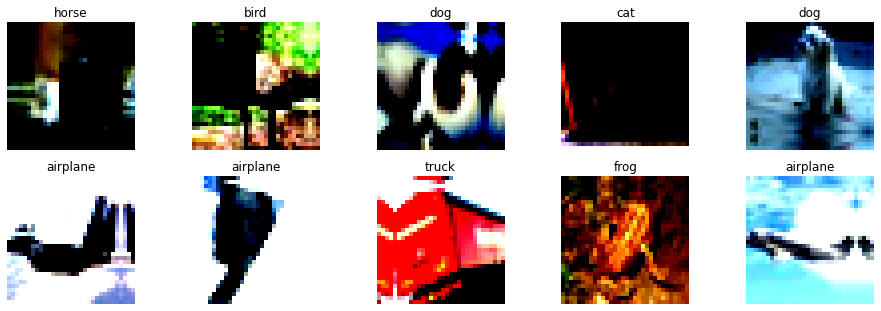

In [11]:
#@title Visualizing Images

from utils.plot_utils import show_batch
show_batch(train_loader,labels,num_images=10) # for visualizing images

In [12]:
#@ Network : Loading Model and understand params, summary
from models.model9 import TransformerUltimus # Model
from utils.summary import print_summary
# from utils.helper import model_summary

net = TransformerUltimus().to(device)

# model_summary(model, input_size =(3, 32, 32))
print_summary(net, input_size =(3, 32, 32), device = device )

Layer (type (var_name))                  Param #                   Kernel Shape              Input Shape               Output Shape
TransformerUltimus (TransformerUltimus)  --                        --                        [8, 3, 32, 32]            [8, 10]
├─Sequential (conv)                      --                        --                        [8, 3, 32, 32]            [8, 48, 32, 32]
│    └─Conv2d (0)                        432                       [3, 3]                    [8, 3, 32, 32]            [8, 16, 32, 32]
│    └─ReLU (1)                          --                        --                        [8, 16, 32, 32]           [8, 16, 32, 32]
│    └─BatchNorm2d (2)                   32                        --                        [8, 16, 32, 32]           [8, 16, 32, 32]
│    └─Conv2d (3)                        4,608                     [3, 3]                    [8, 16, 32, 32]           [8, 32, 32, 32]
│    └─ReLU (4)                          --                       

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.83E-04


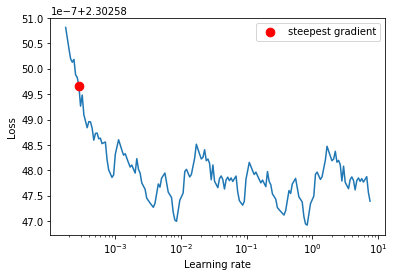

LR at lowest Loss is 0.830994194935339


In [13]:
#@title One Cycle Policy - Finding max and min learning rates
from torch_lr_finder import LRFinder
from utils.lr_utils import find_lr
import torch.optim as optim # for optimizer
import torch.nn as nn # for network, criterion
import copy


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr=1., momentum=0.9)

## make a deep copy of the model ..otherwise this would impact original model
model_copy=copy.deepcopy(net)

max_lr = find_lr(model_copy,optimizer,criterion,test_loader) # sending test set as it does not have augmentations
# max_lr = find_lr(model_copy,optimizer,criterion,train_loader) 



In [14]:
#@title Training and Testing loop

import torch.optim as optim # for optimizer
import torch.nn as nn # for network, criterion
import torch.nn.functional as F 


criterion = nn.CrossEntropyLoss()

# epochs = 40
epochs = 24
lr = 0.1

optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
#                                                  factor=0.1, patience=3, threshold=0.0001, threshold_mode='abs')

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=float(max_lr),
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,## how much percent of cycle to use for building up, this gives 5
                                                div_factor=10,## initial lr max/div_factor
                                                three_phase=False, ## no annihilation 
                                                final_div_factor=50,## min lr max/div_factor
                                                anneal_strategy='linear'
                                                ) 



In [21]:
from main import trainer, train, test # including wrapper function of train and test
train_accuracy, train_losses, test_accuracy, test_losses = trainer(net,device, train_loader, test_loader, optimizer,epochs,criterion,scheduler)


EPOCH: 1


Loss=2.302584171295166 Batch_id=390 Accuracy=10.01: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 20.75it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.27it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.19it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:19<00:00, 20.36it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:19<00:00, 20.01it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.33it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.67it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 10


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:19<00:00, 20.14it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 11


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.38it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 12


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:19<00:00, 20.54it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 13


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 14


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.38it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 15


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:19<00:00, 20.01it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 16


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.26it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 17


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:19<00:00, 20.47it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 18


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:23<00:00, 16.95it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 19


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.06it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 20


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 21


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.05it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 22


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.54it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 23


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:19<00:00, 19.76it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)

EPOCH: 24


Loss=2.302584171295166 Batch_id=390 Accuracy=10.00: 100%|██████████| 391/391 [00:18<00:00, 21.10it/s]



Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10.00%)



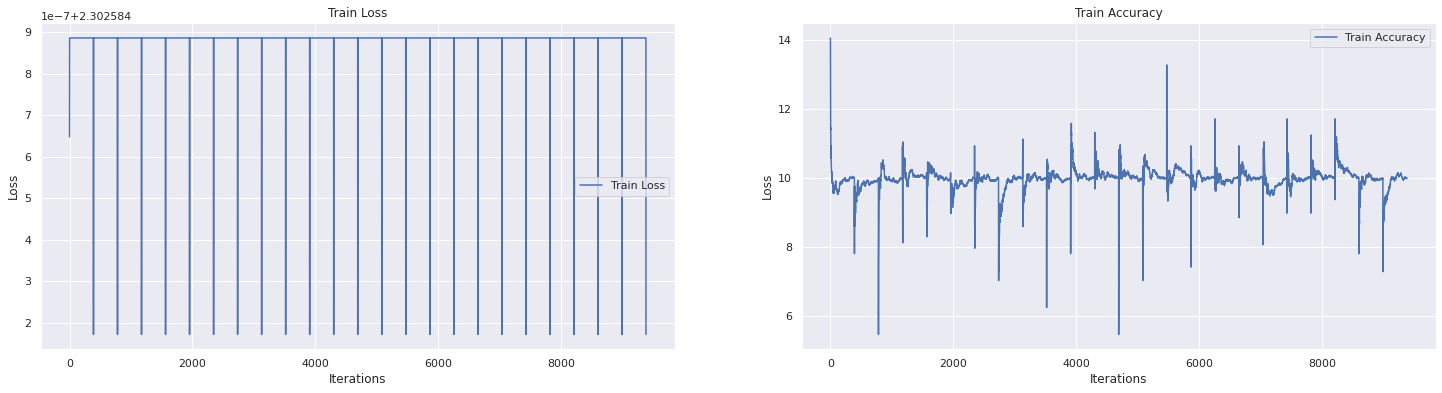

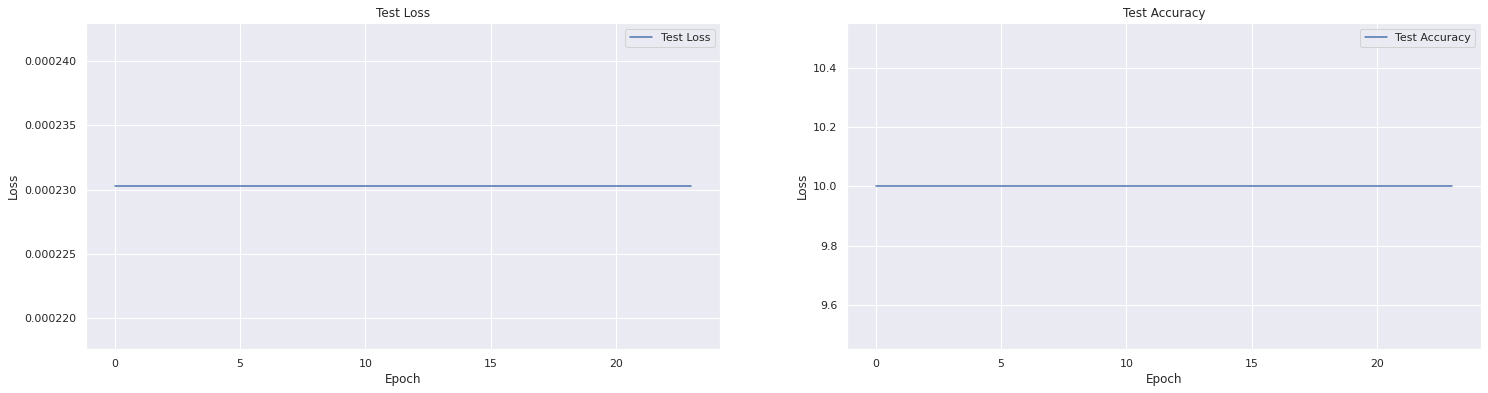

In [22]:
#@title checking results
from utils.plot_utils import plot_metrics

plot_metrics(train_accuracy, [x.cpu().detach().numpy() for x in train_losses], test_accuracy, test_losses)

In [24]:
#@title Checking class level accuracy
from utils.helper import evaluate_classwise_accuracy
evaluate_classwise_accuracy(net, device, labels, test_loader)

Accuracy of airplane : 100 %
Accuracy of automobile :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


Total wrong predictions are 9000


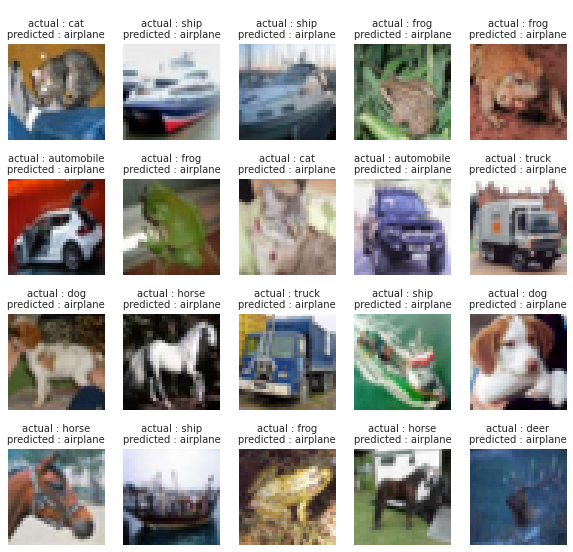

In [25]:
#@title Misclassified Images
from utils.plot_utils import misclassified_images

images_misclassified = misclassified_images(net, test_loader, device, mean, std)